# Load MIMIC-IV ED data

This notebook requires data access to [MIMIC-IV ED](https://physionet.org/content/mimic-iv-ed/). 

It expects that `data` is mapped to physionet.org/files/, which contains:
- mimiciv/1.0/
- mimic-iv-ed/1.0/

In [2]:
import os
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")



COLUMNS_TO_KEEP = [
    "subject_id",
    "hadm_id",
    "ethnicity",
    # 'race',
    'language',
    "gender",
    "age_at_visit",
]


def adm_count(x):
    """Counts previous admissions for a subject's visits"""
    tmp = pd.Series(index=x.index)
    tmp.loc[x.index[0]] = 0
    tmp.iloc[1:] = (~x.iloc[:-1]["hadm_id"].isna()).cumsum()
    tmp.name = "prev_adm"

    return tmp


def age_at_visit(df):
    """Get the age of the patient at their visit.
    anchor_age: age at anchor year.
    anchor_year: randomized year to anchor patient data.
    intime: intime for the patient in the ed.

    age at visit is the anchor_age plus the intime year minus the anchor_year.
    """
    anchor_age = df["anchor_age"].values
    anchor_year = df["anchor_year"].copy()
    intime = pd.to_datetime(df["intime"].copy())
    year_delta = np.asarray([it.year - ay for it, ay in zip(intime, anchor_year)])
    age_at_visit = anchor_age + year_delta

    return age_at_visit


def process_data(
    mimic_path="./data",
    admissions_file="mimiciv/1.0/core/admissions.csv.gz",
    ed_file="mimic-iv-ed/1.0/ed/edstays.csv.gz",
    patients_file="mimiciv/1.0/core/patients.csv.gz",
    results_path="mimic-iv-admissions.2025-07-14.csv",
):
    print("loading and processing mimic files...")
    adm = pd.read_csv(os.path.join(mimic_path, admissions_file))
    print('adm',adm.columns)
    ed = (
        pd.read_csv(os.path.join(mimic_path, ed_file))
        .dropna(subset='hadm_id')
        .astype({'hadm_id':int})
    )
    print('ed',ed.columns)
    pat = pd.read_csv(os.path.join(mimic_path, patients_file))
    print('pat',pat.columns)

    print("merging...")
    df = (
        ed
        .merge(adm, on=["hadm_id",'subject_id'])
        .merge(pat.drop(columns=["dod"]), on="subject_id")
        .dropna(subset=['hadm_id'])
        .drop_duplicates(subset="stay_id")
        .drop_duplicates(subset="hadm_id")
        .set_index("stay_id")
    )
    print(df)

    df["age_at_visit"] = age_at_visit(df)

    print("dropping columns...")
    print(df.columns)
    df = df[COLUMNS_TO_KEEP]

    df = df[df['ethnicity'].isin(['WHITE', 'ASIAN', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO',  'AMERICAN INDIAN/ALASKA NATIVE'])]
    print("dataset columns:", df.columns)
    print(df.head())
    print("done.")
    return df

df = process_data()

print(len(df),'records')

loading and processing mimic files...
adm Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'ethnicity', 'edregtime',
       'edouttime', 'hospital_expire_flag'],
      dtype='object')
ed Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime'], dtype='object')
pat Index(['subject_id', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod'],
      dtype='object')
merging...
          subject_id   hadm_id               intime              outtime  \
stay_id                                                                    
35420907    10000764  27897940  2132-10-14 19:31:00  2132-10-14 23:32:59   
33780565    10003299  28891311  2178-12-10 17:04:00  2178-12-10 21:36:00   
39680380    10003299  21404960  2179-06-30 09:18:00  2179-06-30 16:35:45   
32908139    10003299  29323205  2181-10-22 11:46:00  2181-10-22 19:09:15   
31

In [41]:
# import pandas as pd
# df = pd.read_csv('mimic4_admissions.2024-03-11.csv')
groups = ['gender','age bin', 'language', 'ethnicity']
df['age bin'] = pd.cut(df['age_at_visit'],bins=[0,23,46,68,104]) #,labels=['Q1','Q2','Q3','Q4'])
df['language'] = df['language'].apply(lambda x: 'Other' if x == '?' else x)
df = df.dropna()
df

,subject_id,hadm_id,ethnicity,language,gender,age_at_visit,age bin
stay_id,,,,,,,
35420907,10000764,27897940,WHITE,ENGLISH,M,86,"(68, 104]"
33780565,10003299,28891311,BLACK/AFRICAN AMERICAN,ENGLISH,F,70,"(68, 104]"
39680380,10003299,21404960,BLACK/AFRICAN AMERICAN,ENGLISH,F,71,"(68, 104]"
32908139,10003299,29323205,BLACK/AFRICAN AMERICAN,ENGLISH,F,73,"(68, 104]"
31931401,10003299,21476780,BLACK/AFRICAN AMERICAN,ENGLISH,F,75,"(68, 104]"
...,...,...,...,...,...,...,...
33419639,19998203,26033742,WHITE,ENGLISH,M,29,"(23, 46]"
32237509,19998350,27108332,BLACK/AFRICAN AMERICAN,ENGLISH,M,53,"(46, 68]"
32922923,19998350,21130518,BLACK/AFRICAN AMERICAN,ENGLISH,M,56,"(46, 68]"


In [42]:
dfg = df.groupby(groups)['hadm_id'].count().unstack().unstack()
dfg

ethnicity        AMERICAN INDIAN/ALASKA NATIVE         ASIAN        \
language                               ENGLISH Other ENGLISH Other   
gender age bin                                                       
F      (0, 23]                              10     0     406    42   
       (23, 46]                             82     0     700   238   
       (46, 68]                             81     5     533   699   
       (68, 104]                           107     3     312  1115   
M      (0, 23]                               7     0     277    31   
       (23, 46]                             61     0     567   151   
       (46, 68]                            142     4     550   728   
       (68, 104]                            67     0     370   973   

ethnicity        BLACK/AFRICAN AMERICAN       HISPANIC/LATINO         WHITE  \
language                        ENGLISH Other         ENGLISH Other ENGLISH   
gender age bin                                                                
F      (0, 23]                      724    32             277    35    2991   
       (23, 46]                    4581   203            1371   497   12061   
       (46, 68]                    8273   519            1231  1349   22452   
       (68, 104]                   6353  1014             285  1464   27426   
M      (0, 23]                      558    18             220    53    2478   
       (23, 46]                    3999   160            1536   691   12150   
       (46, 68]                    7835   548            1294  1492   29137   
       (68, 104]                   3279   715             231   954   24155   

ethnicity               
language         Other  
gender age bin          
F      (0, 23]      14  
       (23, 46]    173  
       (46, 68]    428  
       (68, 104]  2715  
M      (0, 23]      19  
       (23, 46]    156  
       (46, 68]    446  
       (68, 104]  1969

# power analysis

In [74]:
import scipy.stats
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt

power_analysis = smp.TTestIndPower()

min_sample_size = {}
effect_sizes = [0.5, 0.3, 0.1, 0.05]
for effect_size in effect_sizes:
    sample_size = power_analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05, alternative='two-sided')
    min_sample_size[effect_size] = sample_size
    print(effect_size,round(sample_size))

0.5 64
0.3 175
0.1 1571
0.05 6280


In [195]:
import itertools as it

groups = {}
large_enough_groups = {}
pct_large_enough_groups = {}
pct_large_enough_groups_inter = {}
frames = []
total_groups = {}
for r in [1,2,3,4]:
    total_groups[r] = 0
    for gs in it.combinations(['gender','age bin','ethnicity','language'],r):
        combo_size=1
        for g in gs:
            combo_size *= df[g].nunique()
        total_groups[r] += combo_size 
    # print( 
    print(f'total {r}-way groups:',total_groups[r])
    
for effect_size, r in it.product(effect_sizes,[1,2,3,4]):
    large_enough_groups[(effect_size,r)] = 0
    groups[r] = []
    for g in it.combinations(['gender','age bin','ethnicity','language'],r):
        dfgb = df.groupby(list(g))
        groups[r].extend(list(dfgb.groups.keys()))
        for idx,dfg in dfgb:
            if len(dfg) >= min_sample_size[effect_size]:
                large_enough_groups[(effect_size, r)] += 1
    pct_large_enough_groups[(effect_size,r)] = large_enough_groups[(effect_size, r)]/270*100
    pct_large_enough_groups_inter[(effect_size,r)] = large_enough_groups[(effect_size, r)]/total_groups[r]*100
    frames.append({
        'Disparity Effect Size': effect_size,
        'Subgroup': f'{r}-way Intersections' if r!=1 else 'Single Attributes',
        'N large enough groups': large_enough_groups[(effect_size, r)],
        '% of Subgroups Large Enough to Detect Effect': pct_large_enough_groups_inter[(effect_size, r)],
        '% of Subgroups Large Enough to Detect Effect (out of all)': pct_large_enough_groups[(effect_size, r)]
    })
        # print(g)
    # print(groups[r])

df_plt = pd.DataFrame(frames)

df_tmp = df_plt.groupby('Disparity Effect Size', as_index=False)['N large enough groups'].sum()
df_tmp['Subgroup'] = 'All'
df_tmp['% of Subgroups Large Enough to Detect Effect'] = df_tmp['N large enough groups']/270
df_tmp['% of Subgroups Large Enough to Detect Effect (out of all)'] = float('nan')
df_plt = pd.concat([df_plt,df_tmp])
df_plt

total 1-way groups: 13
total 2-way groups: 60
total 3-way groups: 116
total 4-way groups: 80


,Disparity Effect Size,Subgroup,N large enough groups,% of Subgroups Large Enough to Detect Effect,% of Subgroups Large Enough to Detect Effect (out of all)
0,0.50,Single Attributes,13,100.000000,4.814815
1,0.50,2-way Intersections,58,96.666667,21.481481
2,0.50,3-way Intersections,104,89.655172,38.518519
3,0.50,4-way Intersections,61,76.250000,22.592593
4,0.30,Single Attributes,13,100.000000,4.814815
5,0.30,2-way Intersections,57,95.000000,21.111111
6,0.30,3-way Intersections,93,80.172414,34.444444
7,0.30,4-way Intersections,52,65.000000,19.259259
8,0.10,Single Attributes,12,92.307692,4.444444
9,0.10,2-way Intersections,48,80.000000,17.777778


# venn diagram and effect size figure

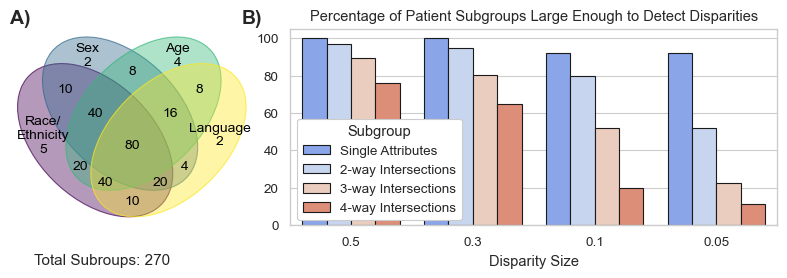

In [208]:
import numpy as np
dems = {
'Race/\nEthnicity': ['American Indian / Alaskan Native','Asian','Black / African American','Hispanic / Latino','White' ],
'Sex': ['M','F'],
'Age': ['<23','23-46','47-68','69+'],
'Language': ['English','Other']
}

import itertools as it
i=0
sets = {}
dem_combos = [item for  i in np.arange(1,len(dems)+1) for item in list(it.combinations(dems.keys(), i))]

for dc in dem_combos:
    subdem = {k:dems[k] for k in dc}
    for x in it.product(*subdem.values()):
#         if i < 10: 
#             print(x)
        i += 1
        for d in dems.keys():
            if d in dc:
                if d not in sets: sets[d] = set()
                sets[d].add(x)
                
# print(i,'total combos')
# print(sets)
import matplotlib.pyplot as plt
from venn import venn, draw_venn
from venn import generate_petal_labels, generate_colors
petal_labels = generate_petal_labels(sets.values(), fmt="{size}")
# print(petal_labels)
for i,k in enumerate(sets.keys()):
    pk = list('0000')
    pk[i] = '1'
    pk = ''.join(pk) 
    petal_labels[pk] = f'{k}\n{petal_labels[pk]}'
# venn(sets, 
#      ax=ax, 
#      legend_loc=[.7,.8],
#      cmap='Set2'     ,
#      labels=petal_labels
#     )


# fig, ax = plt.subplots(1)
fig,axes = plt.subplots(1,2,figsize=(8,3),width_ratios=[1,2])
ax=axes[0]
size=4
draw_venn(
    petal_labels=petal_labels, 
    dataset_labels=sets.keys(),
    hint_hidden=False, colors=generate_colors(n_colors=len(sets.keys())),
    figsize=(3,6), 
    fontsize=10, 
    legend_loc=None, 
    ax=ax
)
ax.axis('tight')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# ax.text(xlim[0],ylim[1],'A)',va='top')
ax.text(0,1.1,'A)',fontsize=14,fontweight='bold',va='top',transform=ax.transAxes)
ax.text(0.1,-.2,'Total Subroups: 270',fontsize=11,transform=ax.transAxes)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_xlim(np.array(ax.get_xlim())*.9)
# ax.legend().remove()

import seaborn as sns
sns.set_theme('paper',font_scale=1.1)
sns.set_style('whitegrid')
# plt.figure(figsize=(12,4))
ax = sns.barplot(
    ax=axes[1],
    data=df_plt,
    x='Disparity Effect Size',
    order=effect_sizes,
    y='% of Subgroups Large Enough to Detect Effect',
    hue='Subgroup',
    # hue_order = ['All'] + [f'{i}-way Intersections' for i in [2,3,4]]
    hue_order = ['Single Attributes'] + [f'{i}-way Intersections' for i in [2,3,4]],
    # palette='Spectral',
    palette='coolwarm',
    edgecolor='k'
)
plt.legend(loc=[0.015,0.025],framealpha=1,title='Subgroup')
ax.set_title('Percentage of Patient Subgroups Large Enough to Detect Disparities')#, MIMIC-IV-ED ')
ax.set_ylabel('')
ax.set_xlabel('Disparity Size')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(-0.1,1.1,'B)',fontsize=14,fontweight='bold',va='top',transform=ax.transAxes)

# plt.legend(labels[:-2], ncol=6)
# ax.set_legend(title='Number of groups')
# plt.legend(title='Number of groups')
fig.tight_layout()
# plt.savefig('venn_dems_mimic-iv.pdf',dpi=300)

# plt.savefig('venn_dems_mimic-iv.tif',dpi=300)

fig.subplots_adjust(wspace=0.1)
plt.savefig('venn_and_barplot_adequately_sized_groups.tiff',dpi=400, bbox_inches='tight')